# Project 4

## Group Number 6

### Team Members
- Baraa Nidal Ghannoum
- Tom Mantel
- Mubarik Omar Ali Abdi


Abstract:


Intro:

Topic 1

Task 0

In [21]:
# Task 0: Install mw_plot library
!pip install mw_plot


In [22]:
import mw_plot
print("mw_plot successfully installed and imported!")
#to make srure the library is installed and working, we can run a simple command


mw_plot successfully installed and imported!


Task 1

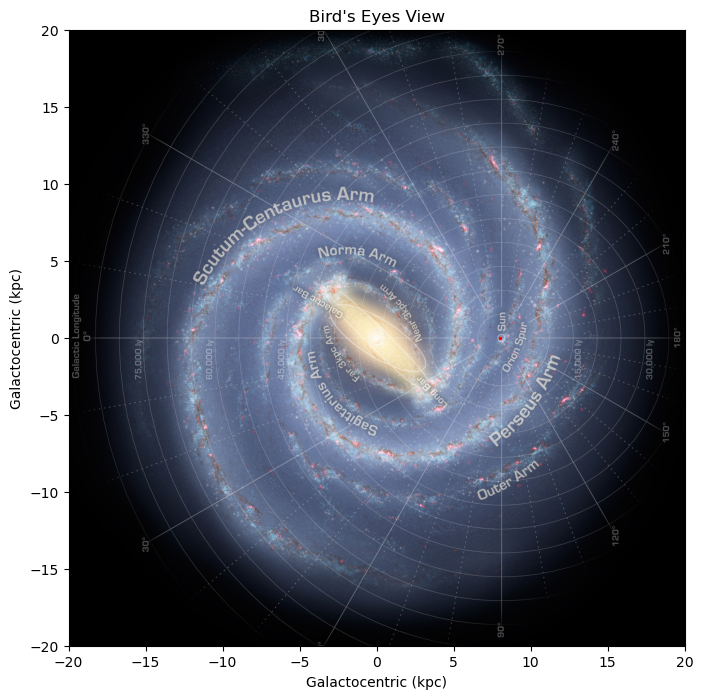

In [23]:
# Task 1: Create a simple plot using mw_plot
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)


mw1.title = "Bird's Eyes View"
mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)


Task 2

As we need to measure the brightness of the galaxy at different radiuses, we go to data reduction, aka 2-D to 1-D curves. We convert the RGB into luminance, and convert the pixel positions to galactrocenctric coordinates, which should in the end showcase a graph coresponding brightness vs radius.

min: 0 max: 255


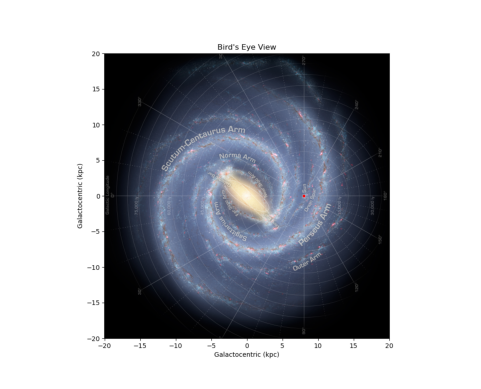

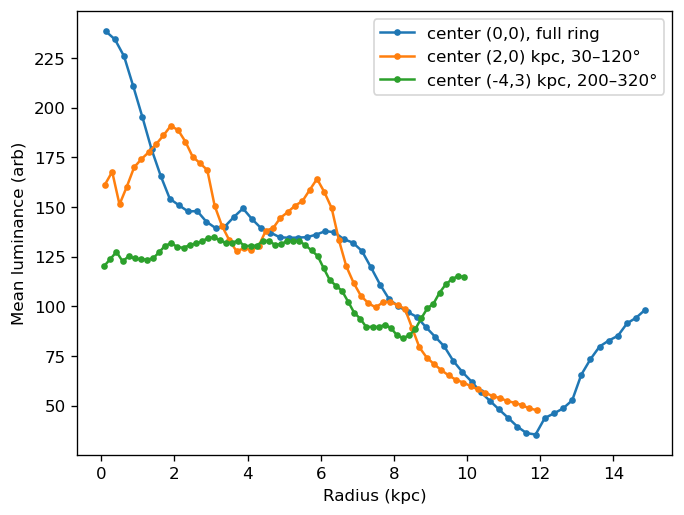

In [19]:
# Task 2: building the visualizations

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWFaceOn
from matplotlib.colors import rgb_to_hsv

def render_faceon(radius=20*u.kpc, figsize=(10,8)):
    # Let MWFaceOn create and use its own figure, like in Task 1
    mw = MWFaceOn(
        radius=radius,
        unit=u.kpc,
        coord="galactocentric",
        annotation=True,
        figsize=figsize,
    )

    mw.title = "Bird's Eye View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=10)

    # Get the figure MWFaceOn is actually using
    fig = plt.gcf()
    fig.canvas.draw()

    # Read pixels from that figure
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_rgba = buf.reshape(h, w, 4)

    # Drop alpha → RGB
    img = img_rgba[..., :3].copy()

    plt.close(fig)

    extent = (-radius.value, radius.value, -radius.value, radius.value)
    return img, extent

def radial_profile_sector(rgb, extent, center=(0,0), rmax=12.0, nrbins=60,
                          theta_deg=(0, 360)):
    # colour -> grayscale
    lum = (0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]).astype(float)

    xmin, xmax, ymin, ymax = extent
    h, w = lum.shape
    xs = np.linspace(xmin, xmax, w)
    ys = np.linspace(ymin, ymax, h)
    X, Y = np.meshgrid(xs, ys)

    xc, yc = center
    R = np.sqrt((X-xc)**2 + (Y-yc)**2)
    T = (np.degrees(np.arctan2(Y-yc, X-xc)) + 360) % 360

    t1, t2 = theta_deg
    if t1 <= t2:
        sector = (T>=t1) & (T<=t2)
    else:
        sector = (T>=t1) | (T<=t2)

    r_edges = np.linspace(0, rmax, nrbins+1)
    prof = np.zeros(nrbins)
    for i in range(nrbins):
        mask = (R>=r_edges[i]) & (R<r_edges[i+1]) & sector
        prof[i] = lum[mask].mean() if np.any(mask) else np.nan
    r_centers = 0.5*(r_edges[:-1] + r_edges[1:])
    return r_centers, prof

# rendering the image once
rgb_array, extent = render_faceon(radius=20*u.kpc)

print("min:", rgb_array.min(), "max:", rgb_array.max())
plt.imshow(rgb_array); plt.axis("off"); plt.show()

# three different profiles (different centers, radiuses, sectors)
configs = [
    {"center":(0,0),   "rmax":15, "theta_deg":(0,360),  "label":"center (0,0), full ring"},
    {"center":(2,0),   "rmax":12, "theta_deg":(30,120), "label":"center (2,0) kpc, 30–120°"},
    {"center":(-4,3),  "rmax":10, "theta_deg":(200,320),"label":"center (-4,3) kpc, 200–320°"},
]

plt.figure(dpi=120)

for cfg in configs:
    cfg_clean = {k: v for k, v in cfg.items() if k != "label"}
    r, y = radial_profile_sector(rgb_array, extent, **cfg_clean)
    plt.plot(r, y, marker=".", label=cfg["label"])

plt.xlabel("Radius (kpc)")
plt.ylabel("Mean luminance (arb)")
plt.legend()
plt.show()

Task 3

We will capture and render figures directly from matplotlib, and it will return a numpy array representing the image.

(1200, 1500, 3) uint8


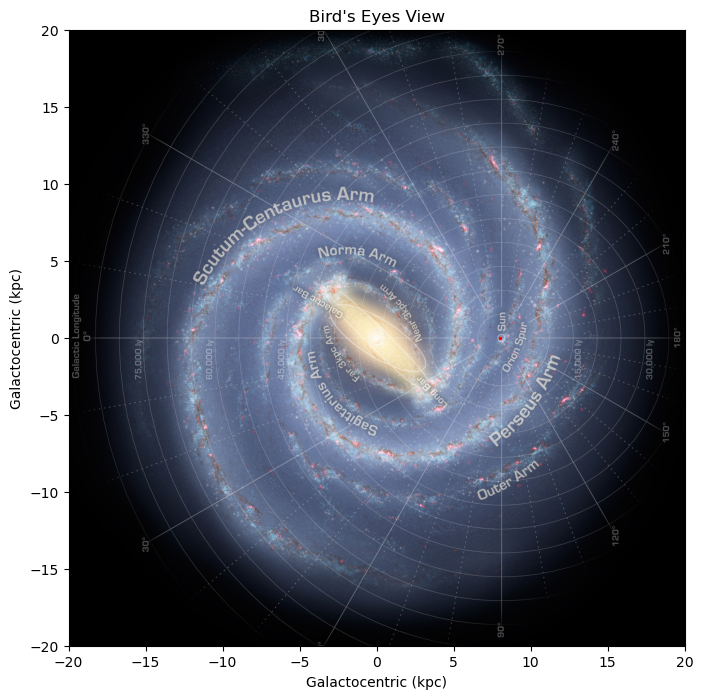

In [25]:
# Do note that we need the rgb array to be named as rgb_array for the code to work

#calling the renderer from task 2 into the code

rgb_array, extent = render_faceon(radius=20*u.kpc)
print(rgb_array.shape, rgb_array.dtype)

Task 4

Each RGB channel (0–255) is broken into 4 ranges

Every pixel gets mapped to a category number (0 to 63)

In [14]:
# A

def color_bins(rgb, k=4):
    # rgb is advised to be in the uint8 format.
    bins = np.linspace(0, 256, k+1)
    r = np.digitize(rgb[...,0], bins) - 1
    g = np.digitize(rgb[...,1], bins) - 1
    b = np.digitize(rgb[...,2], bins) - 1
    #this is combined into a single integer label
    labels = (r * k + g) * k + b
    return labels

labels_bins = color_bins(rgb_array, k=4)  # categories per channel

Task 5

Rendered image shape: (1200, 1500, 3) dtype: uint8


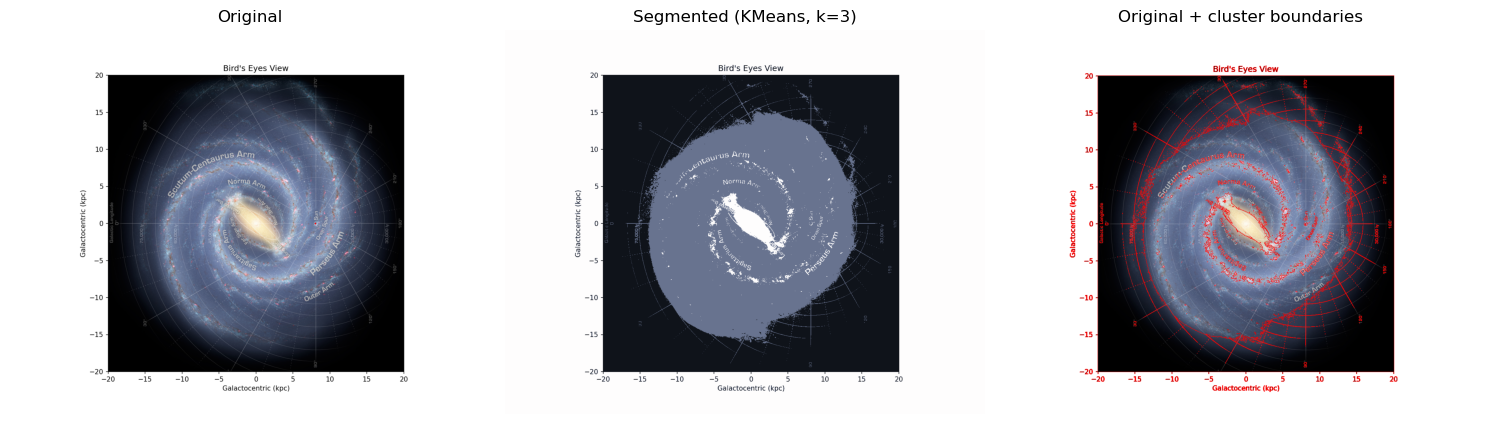

In [27]:
# Task 5: Apply K-means clustering to Milky Way image data

from sklearn.cluster import KMeans

def render_faceon(radius=20*u.kpc, figsize=(10,8), dpi=150):
    # Create MWFaceOn (it may create its own figure internally)
    mw = MWFaceOn(radius=radius, unit=u.kpc, coord="galactocentric",
                  annotation=True, figsize=figsize)
    mw.title = "Bird's Eyes View"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=2)

    # Try to get the figure object used by MWFaceOn
    fig = getattr(mw, "fig", None) or getattr(mw, "figure", None) or plt.gcf()

    # Ensure size
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    fig.canvas.draw()

    # Read RGBA buffer from the correct canvas
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img_rgba = buf.reshape(h, w, 4)
    img_rgb = img_rgba[..., :3].copy()  # shape (H, W, 3), dtype uint8

    # Close the figure to avoid extra notebook outputs
    plt.close(fig)

    extent = (-radius.value, radius.value, -radius.value, radius.value)
    return img_rgb, extent

def kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=None, show=True):
    # Reshape to (num_pixels, 3)
    h, w, _ = rgb_array.shape
    pixels = rgb_array.reshape(-1, 3).astype(float) / 255.0  # normalize

    # Optionally subsample for speed
    if subsample is not None and subsample < pixels.shape[0]:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(pixels.shape[0], size=subsample, replace=False)
        sample = pixels[sample_idx]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(sample)
        labels = kmeans.predict(pixels)
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(pixels)
        labels = kmeans.labels_

    # Build segmented image using cluster centers as colors
    centers = (kmeans.cluster_centers_ * 255).astype(np.uint8)
    segmented = centers[labels].reshape(h, w, 3)

    # Build label image and compute simple boundaries
    label_img = labels.reshape(h, w)
    boundary = np.zeros((h, w), dtype=bool)
    boundary[:, :-1] |= label_img[:, :-1] != label_img[:, 1:]
    boundary[:-1, :] |= label_img[:-1, :] != label_img[1:, :]

    # Overlay boundaries on original (red lines)
    overlay = rgb_array.copy().astype(np.uint8)
    overlay[boundary] = np.array([255, 0, 0], dtype=np.uint8)

    if show:
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        axes[0].imshow(rgb_array)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(segmented)
        axes[1].set_title(f"Segmented (KMeans, k={n_clusters})")
        axes[1].axis("off")

        axes[2].imshow(overlay)
        axes[2].set_title("Original + cluster boundaries")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

    return segmented, label_img, overlay
# Example usage:
# 1) Render the face-on image (no extra empty figures)
rgb_array, extent = render_faceon(radius=20*u.kpc)
print("Rendered image shape:", rgb_array.shape, "dtype:", rgb_array.dtype)

# 2) Segment with KMeans (use subsample for large images, e.g., subsample=100000)
segmented, labels, overlay = kmeans_segment_and_overlay(rgb_array, n_clusters=3, subsample=100000)



Task 6

build a colour for each cluster from its centroid, better than randomly assigning colours to each cluster because:
If you color each cluster with a random color (e.g. cyan, pink, neon green):

-cluster 0 might represent the dark background, but appear red
-cluster 1 might represent the bright bulge, but appear black
-cluster 2 might represent the blue spiral arms, but appear yellow

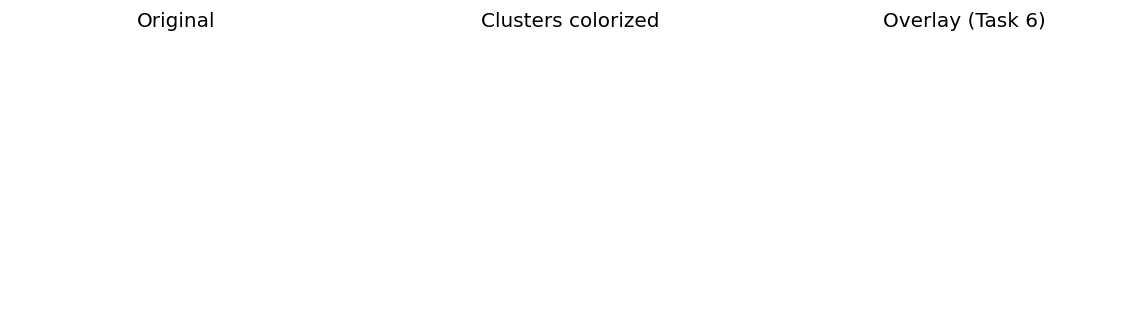

In [8]:
import numpy as np
import matplotlib.pyplot as plt

centroids = kmeans.cluster_centers_.astype(np.uint8)     # shaping (K,3)
palette   = centroids

seg_rgb = palette[clustered_image]                       # (H,W,3) uint8

alpha = 0.5                                              
overlay = (alpha*seg_rgb + (1-alpha)*rgb_array).astype(np.uint8)

plt.figure(figsize=(12,4), dpi=120)
plt.subplot(1,3,1); plt.imshow(rgb_array);   plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seg_rgb);     plt.title("Clusters colorized"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay);     plt.title("Overlay (Task 6)");   plt.axis("off")
plt.show()

Task 7



We will compare the results from task 4 using intertia and solhouette scores. This allows us to understand how the galaxy's structure appear at different clustering levels, and will help us determine a reasonable number of clusters for segmentation.

c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\baraa\anaconda3\Lib\site-packages\s

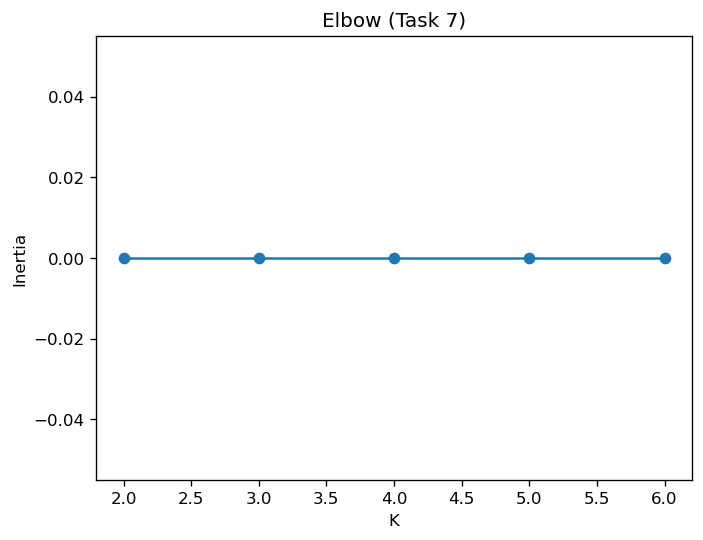

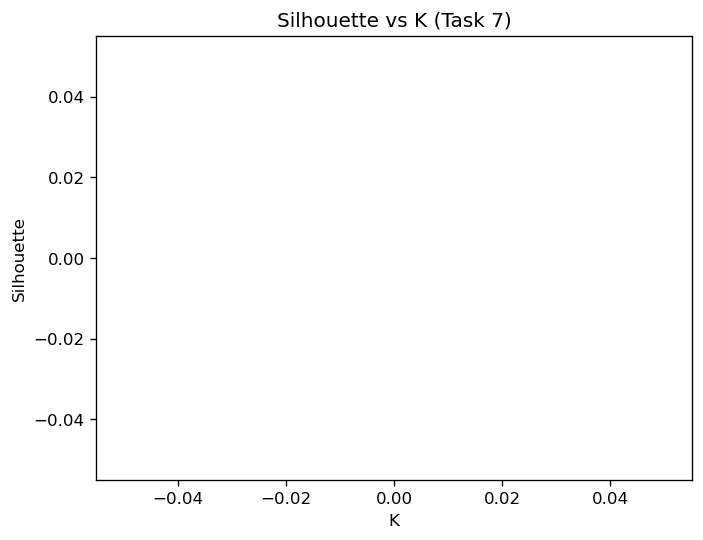

c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


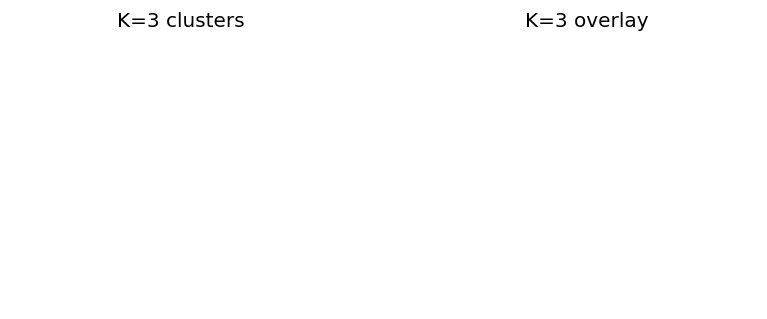

c:\Users\baraa\anaconda3\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


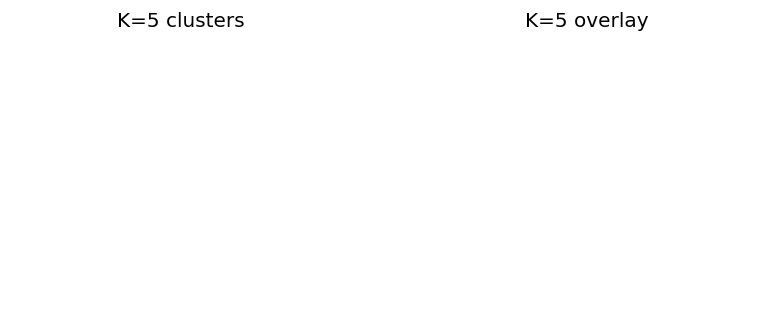

In [9]:
# Task 7: Evaluate K-means clustering with inertia and silhouette scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

H, W, _ = rgb_array.shape
pixels = rgb_array.reshape(-1,3).astype(float)
idx = np.random.choice(pixels.shape[0], size=min(50_000, pixels.shape[0]), replace=False)
sample = pixels[idx] / 255.0

Ks = [2,3,4,5,6]
inertias, sils = [], []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto")
    km.fit(sample)
    inertias.append(km.inertia_)
    # silhouette needs >=2 clusters and all points should not be identical
    try:
        sils.append(silhouette_score(sample, km.predict(sample)))
    except Exception:
        sils.append(np.nan)

plt.figure(dpi=120)
plt.plot(Ks, inertias, marker="o"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow (Task 7)")
plt.show()

plt.figure(dpi=120)
plt.plot(Ks, sils, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette vs K (Task 7)")
plt.show()

for K in [3,5]:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(pixels/255.0)
    seg = km.labels_.reshape(H, W)
    seg_rgb = (km.cluster_centers_*255).astype(np.uint8)[seg]
    overlay = (0.5*seg_rgb + 0.5*rgb_array).astype(np.uint8)

    plt.figure(figsize=(8,3), dpi=120)
    plt.subplot(1,2,1); plt.imshow(seg_rgb); plt.title(f"K={K} clusters"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"K={K} overlay");  plt.axis("off")
    plt.show()